# Ayudantía 12: Tokenización

Por Carlos Olguin, basado en este cuadero de [Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/code)

21 de Noviembre de 2025

## Tokenización y manejo del texto

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Configurar semilla
tf.random.set_seed(42)
URL_DATASET = "https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv"


df = pd.read_csv(URL_DATASET, encoding='latin-1')
print("Pre Limpieza")
print(df.head())

# Manejo! (Limpieza, eliminación nans, etc)
df = df[['v1', 'v2']]
df.columns = ['label', 'text']
df = df.dropna()

# codificación binaria
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

print("Post Limpieza")
print(f"Dimensiones: {df.shape}")
print(df.head())


Pre Limpieza
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
Post Limpieza
Dimensiones: (5572, 3)
  label                                               text  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   h

In [ ]:
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split

# Separación split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label_num'],
    test_size=0.2,
    random_state=42
)

# Hiperparametros
MAX_TOKENS = 5000       # Tamaño vocabulario
SEQUENCE_LENGTH = 40    # Tamaño SMS definido

# Tokenizar con Text-Vectorization
vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS, # Maximo cantidad de vocabulario posible
    output_mode='int', # Mapear palabras a numeros
    output_sequence_length=SEQUENCE_LENGTH, # Si es mas grande el mensaje o menor, se trunca o rellena el SMS
    standardize='lower_and_strip_punctuation' # Lo vuelve minusculas y saca signos de puntuación!, diversos modos de standarizar daran diversos vocabularios y mapeos
)

vectorizer.adapt(X_train.values) # Construye el vocabulario basado en frecuencia, la ventana en esta tokenización es fija y es del SEQUENCE_LENGTH considerando el vocabulario de tamaño MAX_TOKENS!
print("Tokenizador adaptado")
print(f"Vocabulario aprendido: {len(vectorizer.get_vocabulary())} palabras.")

Tokenizador adaptado
Vocabulario aprendido: 5000 palabras.


## Resultados y visualización de tokenización

In [ ]:
# Probamos con un mensaje tipo Spam
frase_spam = "URGENT! You have won a 1 week FREE membership in our Prize Jackpot!"
vector = vectorizer([frase_spam])

print(f"Mensaje original: \n'{frase_spam}'")
print(f"\nVectorizado (Tensor): \n{vector.numpy()}")

# Decodificación
vocab = vectorizer.get_vocabulary() # Diccionario gigante!
print("Mapeo observado")
print(f"El número {vector[0][0]} es la palabra '{vocab[vector[0][0]]}'")
print(f"El número {vector[0][1]} es la palabra '{vocab[vector[0][1]]}'")

Mensaje original: 
'URGENT! You have won a 1 week FREE membership in our Prize Jackpot!'

Vectorizado (Tensor): 
[[ 190    4   18  172    5  164  117   50 2954    9   93  142    1    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Mapeo observado
El número 190 es la palabra 'urgent'
El número 4 es la palabra 'you'


## Implementación con un modelo (Red Neuronal)

In [ ]:
from tensorflow.keras import models, layers

EMBEDDING_DIM = 16

model = models.Sequential([
    # Capa de entrada del texto
    layers.Input(shape=(1,), dtype=tf.string),

    # Capa de vectorización
    vectorizer,

    # Capa de embedding
    layers.Embedding(input_dim=MAX_TOKENS + 1, output_dim=EMBEDDING_DIM),

    # Capa de pooling
    layers.GlobalAveragePooling1D(),

    # Capa ade clasificación
    layers.Dense(16, activation='relu'),

    # Capa de salida
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 40)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 40, 16)         │        80,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,305 (313.69 KB)

 Trainable params: 80,305 (313.69 KB)

 Non-trainable params: 0 (0.00 B)

## Resultados del modelo

Entrenamiento!
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9985 - loss: 0.0068 - val_accuracy: 0.9794 - val_loss: 0.0809
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9985 - loss: 0.0061 - val_accuracy: 0.9794 - val_loss: 0.0825
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9803 - val_loss: 0.0841
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9990 - loss: 0.0048 - val_accuracy: 0.9803 - val_loss: 0.0857
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9990 - loss: 0.0043 - val_accuracy: 0.9803 - val_loss: 0.0873
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0039 - val_accuracy: 0.9803 - val_loss: 0.0889
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9803 - val_loss: 0.0906
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0032 - v

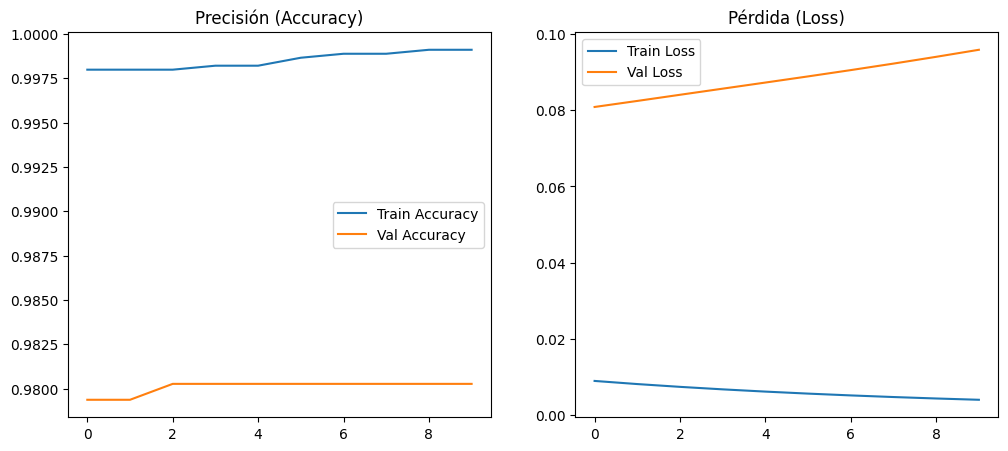

Pérdida Final: 0.0959
Exactitud Final: 98.03%
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


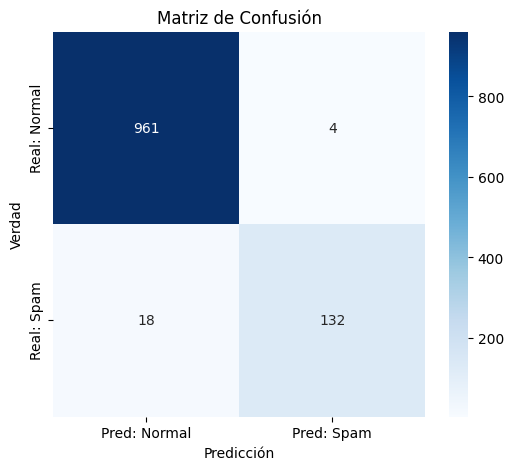

              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       965
        Spam       0.97      0.88      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Test creado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Mensaje: 'Hello mom, are we having dinner tonight?'
Predicción: 0.0000 -> ✅ HAM (Normal)

Mensaje: 'WINNER! You have won a BMW! Call 555-123 now'
Predicción: 0.9589 -> 🚨 SPAM

Mensaje: 'Can you send me the report by tomorrow?'
Predicción: 0.0002 -> ✅ HAM (Normal)

Mensaje: 'FREE ENTRY in a weekly competition to win iPod'
Predicción: 0.3472 -> ✅ HAM (Normal)



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Entrenamiento!")
history = model.fit(
    X_train.values,
    y_train.values,
    epochs=10,
    validation_data=(X_test.values, y_test.values),
    batch_size=32,
    verbose=1
)

# Graficos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Precisión (Accuracy)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.legend()

plt.show()

# Evaluar en test
loss, accuracy = model.evaluate(X_test.values, y_test.values, verbose=0)
print(f"Pérdida Final: {loss:.4f}")
print(f"Exactitud Final: {accuracy*100:.2f}%")


y_pred_probs = model.predict(X_test.values)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Normal', 'Pred: Spam'],
            yticklabels=['Real: Normal', 'Real: Spam'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdad')
plt.xlabel('Predicción')
plt.show()

# Reporte spam/no spam
print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'Spam']))

# Testeo manual!
print("Test creado")
mis_sms = [
    "Hello mom, are we having dinner tonight?",      # No Spam
    "WINNER! You have won a BMW! Call 555-123 now",  # Spam
    "Can you send me the report by tomorrow?",       # No Spam
    "FREE ENTRY in a weekly competition to win iPod" # Spam
]

X_pred = np.array(mis_sms, dtype=object)
preds = model.predict(X_pred)

for sms, pred in zip(mis_sms, preds):
    etiqueta = "🚨 SPAM" if pred > 0.5 else "✅ HAM (Normal)" # Importante el umbral, en base a esto sera spam o no spam
    print(f"Mensaje: '{sms}'")
    print(f"Predicción: {pred[0]:.4f} -> {etiqueta}\n")